In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

#For Document processing
#pip install python-docx 
from collections import Counter
import random
from docx import Document


#For Attention Matrix for 2 
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

'''
devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)

print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")
'''



Using device: cuda


'\ndevNumber = torch.cuda.current_device()\ndevName = torch.cuda.get_device_name(devNumber)\n\nprint(f"Current device number is: {devNumber}")\nprint(f"GPU name is: {devName}")\n'

In [2]:
'''
Problem 1 (30pts)
In this homework, we focus on sequence-to-sequence modeling. Use the English to French Dataset provided. 
Developed a GRU-based encoder-decoder architecture for English to French Translation. 
Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. 
Also, try some qualitative validation as well, asking the network to generate French translations for some English sentences.
'''

# Load dataset from .docx file
def load_english_french_pairs(docx_path):
    doc = Document(docx_path)
    text = "\n".join([p.text for p in doc.paragraphs])
    english_to_french = []
    
    for line in text.split("\n"):
        if '", "' in line:
            en, fr = line.split('", "')
            en = en.replace('("', '').strip()
            fr = fr.replace('")', '').strip()
            english_to_french.append((en, fr))
            
    return english_to_french

# Load dataset
dataset = load_english_french_pairs("Dataset - English to French.docx")


# Vocabulary builder
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            index = len(self.word2index)
            self.word2index[word] = index
            self.index2word[index] = word

    def sentence_to_indices(self, sentence):
        return [self.word2index.get(word, self.word2index["<UNK>"]) for word in sentence.split()] + [self.word2index["<EOS>"]]

# Build vocabularies
english_vocab = Vocabulary()
french_vocab = Vocabulary()

for en, fr in dataset:
    english_vocab.add_sentence(en)
    french_vocab.add_sentence(fr)

# Custom dataset class
class TranslationDataset(Dataset):
    def __init__(self, pairs, english_vocab, french_vocab):
        self.pairs = pairs
        self.english_vocab = english_vocab
        self.french_vocab = french_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        en_sentence, fr_sentence = self.pairs[idx]
        en_indices = self.english_vocab.sentence_to_indices(en_sentence)
        fr_indices = self.french_vocab.sentence_to_indices(fr_sentence)
        
        return torch.tensor(en_indices), torch.tensor(fr_indices)

# Collate function for padding
def collate_fn(batch):
    en_batch = [item[0] for item in batch]
    fr_batch = [item[1] for item in batch]

    en_batch = nn.utils.rnn.pad_sequence(en_batch, batch_first=True, padding_value=english_vocab.word2index["<PAD>"])
    fr_batch = nn.utils.rnn.pad_sequence(fr_batch, batch_first=True, padding_value=french_vocab.word2index["<PAD>"])

    return en_batch, fr_batch

# DataLoader
train_dataset = TranslationDataset(dataset, english_vocab, french_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, hidden_size, device=device),
                torch.zeros(1, batch_size, hidden_size, device=device))

# Decoder with LSTM
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        embedded = self.embedding(x).unsqueeze(1)
        output, hidden = self.lstm(embedded, hidden)
        output = self.softmax(self.fc(output.squeeze(1)))
        return output, hidden

# Training epoch with teacher forcing
def train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        # Use teacher forcing or not
        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            # Use the true target as the next input (teacher forcing)
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                decoder_input = target_tensor[:, t]  # Teacher forcing
        else:
            # Use the model's predictions as the next input
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                # Get the top prediction
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        # Normalize the loss by the sequence length
        loss = loss / target_length

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_and_show_examples(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()
    
    total_loss = 0
    correct_predictions = 0  
    printed_examples = 0
  
    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)

            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden
            loss = 0
            predicted_indices = [[] for _ in range(batch_size)]

            # Generate predictions
            for t in range(target_tensor.size(1)):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Get the top prediction
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())

                decoder_input = topi.squeeze().detach()

                # Stop decoding if all sentences produce EOS
                if all(decoder_input == french_vocab.word2index["<EOS>"]):
                    break
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1            
            
            # Print examples while keeping track of the number of examples printed
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break  # Stop once n_examples have been printed

                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_sentence = " ".join(
                    [english_vocab.index2word[idx.item()] 
                     for idx in input_tensor[batch_idx] 
                     if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]]
                )          
                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                printed_examples += 1  # Increment the counter

    # Calculate and display overall validation loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')

# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
decoder = Decoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

num_epochs = 50 
for epoch in range(num_epochs):
    loss = train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples(encoder, decoder, train_loader, criterion, n_examples)


Epoch 10, Loss: 2.1542
Epoch 20, Loss: 1.3881
Epoch 30, Loss: 0.3528
Epoch 40, Loss: 0.0728
Epoch 50, Loss: 0.0310
Input: She catches the bus
Target: Elle attrape le bus,
Predicted: Elle attrape le bus,
------------------------------
Input: He combs his hair
Target: Il se peigne les cheveux,
Predicted: Il se peigne les cheveux,
------------------------------
Input: The restaurant serves delicious food
Target: Le restaurant sert une délicieuse cuisine,
Predicted: Le restaurant sert une délicieuse cuisine,
------------------------------
Input: The river flows calmly
Target: La rivière coule calmement,
Predicted: La rivière coule calmement,
------------------------------
Input: He turns off the light
Target: Il éteint la lumière,
Predicted: Il éteint la lumière,
------------------------------
Input: She sings a song
Target: Elle chante une chanson,
Predicted: Elle chante une chanson,
------------------------------
Input: The flowers bloom in spring
Target: Les fleurs fleurissent au printe

In [6]:
'''Problem 2 (30pts)
Repeat problem 1, this time extend the network with attention. Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. Also, try some qualitative validation as well, 
asking the network to generate French translations for some English sentences. Also, compare the results against problem 1.
'''

# Load dataset from .docx file
def load_english_french_pairs(docx_path):
    doc = Document(docx_path)
    text = "\n".join([p.text for p in doc.paragraphs])
    english_to_french = []
    
    for line in text.split("\n"):
        if '", "' in line:
            en, fr = line.split('", "')
            en = en.replace('("', '').strip()
            fr = fr.replace('")', '').strip()
            english_to_french.append((en, fr))
            
    return english_to_french

# Load dataset
dataset = load_english_french_pairs("Dataset - English to French.docx")

# Vocabulary builder
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            index = len(self.word2index)
            self.word2index[word] = index
            self.index2word[index] = word

    def sentence_to_indices(self, sentence):
        return [self.word2index.get(word, self.word2index["<UNK>"]) for word in sentence.split()] + [self.word2index["<EOS>"]]

# Build vocabularies
english_vocab = Vocabulary()
french_vocab = Vocabulary()

for en, fr in dataset:
    english_vocab.add_sentence(en)
    french_vocab.add_sentence(fr)

# Custom dataset class
class TranslationDataset(Dataset):
    def __init__(self, pairs, english_vocab, french_vocab):
        self.pairs = pairs
        self.english_vocab = english_vocab
        self.french_vocab = french_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        en_sentence, fr_sentence = self.pairs[idx]
        en_indices = self.english_vocab.sentence_to_indices(en_sentence)
        fr_indices = self.french_vocab.sentence_to_indices(fr_sentence)
        
        return torch.tensor(en_indices), torch.tensor(fr_indices)

# Collate function for padding
def collate_fn(batch):
    en_batch = [item[0] for item in batch]
    fr_batch = [item[1] for item in batch]

    en_batch = nn.utils.rnn.pad_sequence(en_batch, batch_first=True, padding_value=english_vocab.word2index["<PAD>"])
    fr_batch = nn.utils.rnn.pad_sequence(fr_batch, batch_first=True, padding_value=french_vocab.word2index["<PAD>"])

    return en_batch, fr_batch

# DataLoader
train_dataset = TranslationDataset(dataset, english_vocab, french_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, hidden_size, device=device),
                torch.zeros(1, batch_size, hidden_size, device=device))

# Decoder with LSTM
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(AttentionDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.max_length = max_length
        
        self.embedding = nn.Embedding(output_size, embedding_size)
        
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        embedded = self.embedding(x).unsqueeze(1)
        output, hidden = self.lstm(embedded, hidden)
        output = self.softmax(self.fc(output.squeeze(1)))
        return output, hidden

# Training epoch with teacher forcing
def train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        # Use teacher forcing or not
        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            # Use the true target as the next input (teacher forcing)
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                decoder_input = target_tensor[:, t]  # Teacher forcing
        else:
            # Use the model's predictions as the next input
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                # Get the top prediction
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        # Normalize the loss by the sequence length
        loss = loss / target_length

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_and_show_examples(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()
    
    total_loss = 0
    correct_predictions = 0  
    printed_examples = 0
  
    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)

            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden
            loss = 0
            predicted_indices = [[] for _ in range(batch_size)]

            # Generate predictions
            for t in range(target_tensor.size(1)):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Get the top prediction
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())

                decoder_input = topi.squeeze().detach()

                # Stop decoding if all sentences produce EOS
                if all(decoder_input == french_vocab.word2index["<EOS>"]):
                    break
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1            
            
            # Print examples while keeping track of the number of examples printed
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break  # Stop once n_examples have been printed

                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_sentence = " ".join(
                    [english_vocab.index2word[idx.item()] 
                     for idx in input_tensor[batch_idx] 
                     if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]]
                )          
                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                printed_examples += 1  # Increment the counter

    # Calculate and display overall validation loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')

# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
decoder = AttentionDecoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

num_epochs = 50 
for epoch in range(num_epochs):
    loss = train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples(encoder, decoder, train_loader, criterion, n_examples)


NameError: name 'max_length' is not defined

In [47]:
'''Problem 3 (40pts)

Repeat problems 1 and 2, this time try to translate from French to English. Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. 
Also, try some qualitative validation as well, asking the network to generate French translations for some English sentences. 
Which one seems to be more effective, French-to-English or English-to-French?'''

'''Problem 2 (30pts)
Repeat problem 1, this time extend the network with attention. Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. Also, try some qualitative validation as well, 
asking the network to generate French translations for some English sentences. Also, compare the results against problem 1.
'''

# Load dataset from .docx file
def load_english_french_pairs(docx_path):
    doc = Document(docx_path)
    text = "\n".join([p.text for p in doc.paragraphs])
    english_to_french = []
    
    for line in text.split("\n"):
        if '", "' in line:
            en, fr = line.split('", "')
            en = en.replace('("', '').strip()
            fr = fr.replace('")', '').strip()
            english_to_french.append((fr, en))
            
    return english_to_french

# Load dataset
dataset = load_english_french_pairs("Dataset - English to French.docx")


# Vocabulary builder
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            index = len(self.word2index)
            self.word2index[word] = index
            self.index2word[index] = word

    def sentence_to_indices(self, sentence):
        return [self.word2index.get(word, self.word2index["<UNK>"]) for word in sentence.split()] + [self.word2index["<EOS>"]]

# Build vocabularies
english_vocab = Vocabulary()
french_vocab = Vocabulary()

for en, fr in dataset:
    english_vocab.add_sentence(en)
    french_vocab.add_sentence(fr)

# Custom dataset class
class TranslationDataset(Dataset):
    def __init__(self, pairs, english_vocab, french_vocab):
        self.pairs = pairs
        self.english_vocab = english_vocab
        self.french_vocab = french_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        en_sentence, fr_sentence = self.pairs[idx]
        en_indices = self.english_vocab.sentence_to_indices(en_sentence)
        fr_indices = self.french_vocab.sentence_to_indices(fr_sentence)
        
        return torch.tensor(en_indices), torch.tensor(fr_indices)

# Collate function for padding
def collate_fn(batch):
    en_batch = [item[0] for item in batch]
    fr_batch = [item[1] for item in batch]

    en_batch = nn.utils.rnn.pad_sequence(en_batch, batch_first=True, padding_value=english_vocab.word2index["<PAD>"])
    fr_batch = nn.utils.rnn.pad_sequence(fr_batch, batch_first=True, padding_value=french_vocab.word2index["<PAD>"])

    return en_batch, fr_batch

# DataLoader
train_dataset = TranslationDataset(dataset, english_vocab, french_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, hidden_size, device=device),
                torch.zeros(1, batch_size, hidden_size, device=device))

# Decoder with LSTM
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        embedded = self.embedding(x).unsqueeze(1)
        output, hidden = self.lstm(embedded, hidden)
        output = self.softmax(self.fc(output.squeeze(1)))
        return output, hidden

# Training epoch with teacher forcing
def train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        # Use teacher forcing or not
        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            # Use the true target as the next input (teacher forcing)
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                decoder_input = target_tensor[:, t]  # Teacher forcing
        else:
            # Use the model's predictions as the next input
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                # Get the top prediction
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        # Normalize the loss by the sequence length
        loss = loss / target_length

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_and_show_examples(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()
    
    total_loss = 0
    correct_predictions = 0  
    printed_examples = 0
  
    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)

            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden
            loss = 0
            predicted_indices = [[] for _ in range(batch_size)]

            # Generate predictions
            for t in range(target_tensor.size(1)):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Get the top prediction
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())

                decoder_input = topi.squeeze().detach()

                # Stop decoding if all sentences produce EOS
                if all(decoder_input == french_vocab.word2index["<EOS>"]):
                    break
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1            
            
            # Print examples while keeping track of the number of examples printed
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break  # Stop once n_examples have been printed

                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_sentence = " ".join(
                    [english_vocab.index2word[idx.item()] 
                     for idx in input_tensor[batch_idx] 
                     if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]]
                )          
                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                printed_examples += 1  # Increment the counter

    # Calculate and display overall validation loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')

# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
decoder = Decoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

num_epochs = 50 
for epoch in range(num_epochs):
    loss = train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate with examples
evaluate_and_show_examples(encoder, decoder, train_loader, criterion, 5)

Epoch 10, Loss: 2.5659
Epoch 20, Loss: 1.8377
Epoch 30, Loss: 0.8683
Epoch 40, Loss: 0.2955
Epoch 50, Loss: 0.1045
Input: Nous apprenons quelque chose de nouveau chaque jour,
Target: We learn something new every day
Predicted: We learn something new every day
------------------------------
Input: Le film commence à 19 heures,
Target: The movie starts at 7 PM
Predicted: The movie starts at 7 PM
------------------------------
Input: Le soleil se couche le soir,
Target: The sun sets in the evening
Predicted: The sun sets in the evening
------------------------------
Input: Elle attache ses lacets,
Target: She ties her shoelaces
Predicted: She ties her shoelaces
------------------------------
Input: Nous pratiquons le yoga,
Target: We practice yoga
Predicted: We practice yoga
------------------------------
Evaluation Loss: 0.0043, Accuracy: 100.00%


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random

# Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        # Repeat hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate hidden state with encoder outputs
        combined = torch.cat((hidden, encoder_outputs), dim=2)

        # Calculate attention scores
        energy = torch.tanh(self.attn(combined))
        attention = self.v(energy).squeeze(2)  # [batch_size, seq_len]

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention, dim=1)

        # Weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights

# Updated Decoder with Attention
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(AttentionDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        # x: [batch_size]
        # hidden: tuple of (h, c) => LSTM hidden and cell states
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        embedded = self.embedding(x).unsqueeze(1)  # [batch_size, 1, embedding_size]

        # Apply attention
        context, attn_weights = self.attention(hidden[0][-1], encoder_outputs)

        # Combine context and embedding
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)

        # Pass through LSTM
        output, hidden = self.lstm(rnn_input, hidden)

        # Output layer
        output = self.fc(torch.cat((output.squeeze(1), context), dim=1))
        output = self.softmax(output)

        return output, hidden, attn_weights

# Training epoch with attention
def train_epoch_with_attention(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            for t in range(target_length):
                output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(output, target_tensor[:, t])
                decoder_input = target_tensor[:, t]
        else:
            for t in range(target_length):
                output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(output, target_tensor[:, t])
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        loss = loss / target_length
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation with attention
def evaluate_and_show_examples_with_attention(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    correct_predictions = 0
    printed_examples = 0

    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden

            predicted_indices = [[] for _ in range(batch_size)]

            for t in range(target_tensor.size(1)):
                output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())

                decoder_input = topi.squeeze().detach()
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1  
            # Print examples
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break

                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_sentence = " ".join(
                    [english_vocab.index2word[idx.item()] 
                     for idx in input_tensor[batch_idx] 
                     if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]]
                )
                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                printed_examples += 1
        # Calculate and display overall validation loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')

# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

# Initialize encoder and attention decoder
encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
attention_decoder = AttentionDecoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(attention_decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    loss = train_epoch_with_attention(encoder, attention_decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples_with_attention(encoder, attention_decoder, train_loader, criterion, n_examples)


Epoch 10, Loss: 2.2454
Epoch 20, Loss: 0.3699
Epoch 30, Loss: 0.0686
Epoch 40, Loss: 0.0199
Epoch 50, Loss: 0.0114
Input: We play music at the concert
Target: Nous jouons de la musique au concert,
Predicted: Nous jouons de la musique au concert,
------------------------------
Input: The river flows calmly
Target: La rivière coule calmement,
Predicted: La rivière coule calmement,
------------------------------
Input: He drives a blue car
Target: Il conduit une voiture bleue,
Predicted: Il conduit une voiture bleue,
------------------------------
Input: They go shopping
Target: Ils font du shopping,
Predicted: Ils font du shopping,
------------------------------
Input: We eat breakfast together
Target: Nous prenons le petit déjeuner ensemble,
Predicted: Nous prenons le petit déjeuner ensemble,
------------------------------
Input: The sun is shining
Target: Le soleil brille,
Predicted: Le soleil brille,
------------------------------
Input: We practice yoga
Target: Nous pratiquons le yog

Input: The sun sets in the evening
Target: Le soleil se couche le soir,
Predicted: Le soleil se couche le soir,
------------------------------
[[3.58190505e-06 3.09531497e-05 2.98357772e-04 1.07374287e-03
  2.58869631e-03 1.05409063e-02 9.85463798e-01]
 [5.42201906e-06 7.14669586e-05 4.96659311e-04 2.26642797e-03
  5.60913654e-03 3.50256898e-02 9.56525147e-01]
 [1.18349599e-05 5.03004740e-05 2.58799846e-04 7.31645036e-04
  1.57338532e-03 6.47223089e-03 9.90901828e-01]
 [4.27352315e-05 1.53629750e-04 7.60744850e-04 1.59848214e-03
  2.96749268e-03 7.81027181e-03 9.86666620e-01]
 [7.21546212e-06 5.90303644e-05 4.43179131e-04 1.24622579e-03
  2.59204465e-03 8.75814725e-03 9.86894131e-01]
 [1.34523475e-06 2.45338051e-05 2.47116433e-04 8.85464891e-04
  2.25490867e-03 1.62371863e-02 9.80349422e-01]
 [1.49287926e-02 3.87859307e-02 7.56170973e-02 9.05574188e-02
  1.03790566e-01 1.37650624e-01 5.38669586e-01]
 [1.30007640e-01 1.34588167e-01 1.80529535e-01 1.50358766e-01
  1.45352647e-01 1.078430

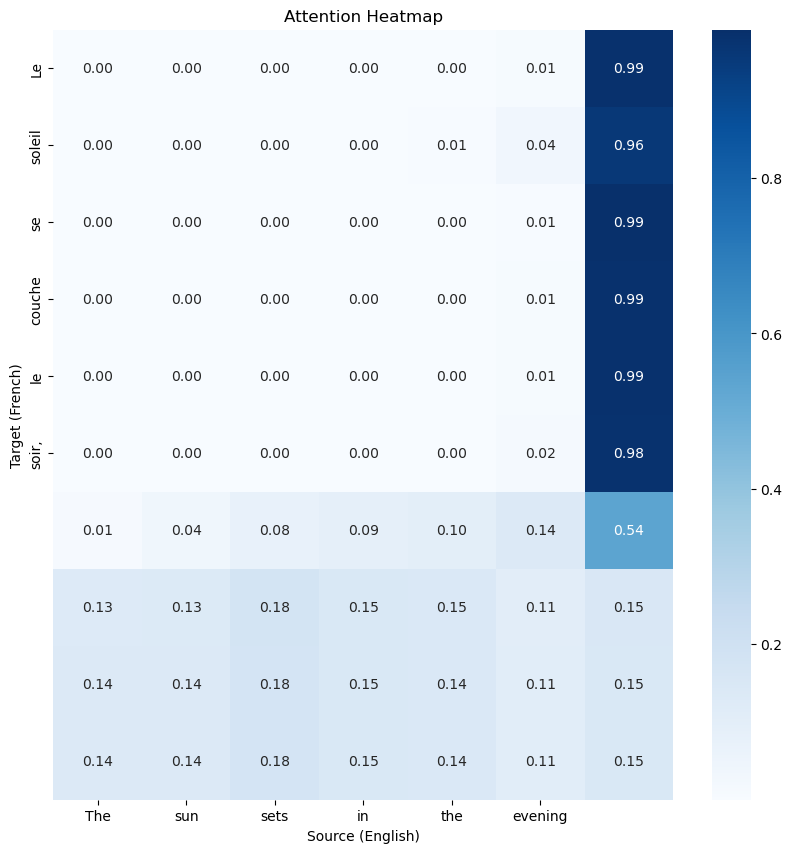

Input: We travel by train
Target: Nous voyageons en train,
Predicted: Nous voyageons en train,
------------------------------
[[5.6881250e-05 8.4418447e-05 5.6343408e-05 9.6801866e-04 9.9800009e-01
  6.1743072e-04 2.1676533e-04]
 [8.1626604e-05 1.1532480e-04 8.9791502e-05 1.2831092e-03 9.9794751e-01
  3.5767123e-04 1.2490401e-04]
 [7.7521912e-04 9.6636225e-04 7.5274694e-04 2.9334074e-03 9.7566199e-01
  1.4631511e-02 4.2789029e-03]
 [1.5739768e-05 2.3281465e-05 1.6858630e-05 2.1835558e-04 9.9219370e-01
  4.1135657e-03 3.4184617e-03]
 [1.4308600e-04 2.0742236e-04 1.1499663e-04 9.0524950e-04 1.4234146e-01
  1.2632218e-01 7.2996557e-01]
 [3.9289515e-03 4.3155225e-03 3.6362463e-03 4.9834251e-03 1.4856374e-02
  2.1556213e-01 7.5271732e-01]
 [4.3928064e-03 4.7078249e-03 4.2206571e-03 5.0160564e-03 1.2862497e-02
  2.0622402e-01 7.6257610e-01]
 [4.2368625e-03 4.5398362e-03 4.0417402e-03 4.8738788e-03 1.2545187e-02
  1.9895755e-01 7.7080488e-01]
 [4.3102545e-03 4.6104477e-03 4.1202251e-03 4.9353

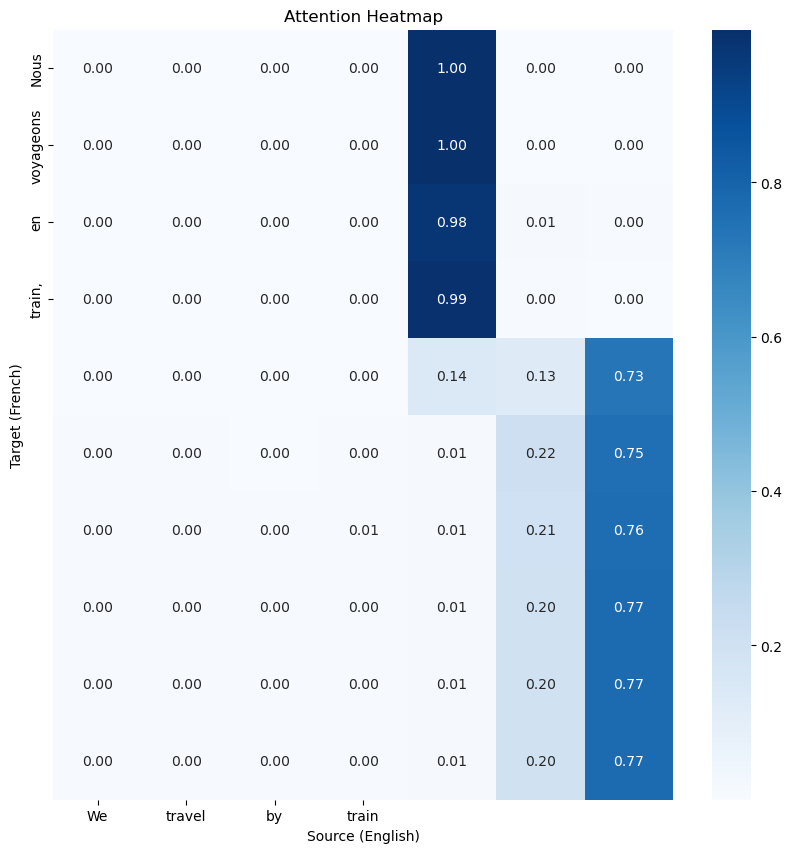

Input: The stars twinkle at night
Target: Les étoiles scintillent la nuit,
Predicted: Les étoiles scintillent la nuit,
------------------------------
[[5.91995104e-07 1.17279444e-06 5.42002817e-05 3.68940498e-04
  1.36920847e-02 9.84760344e-01 1.12260843e-03]
 [2.58509499e-06 4.75247316e-06 1.31523251e-04 1.16641552e-03
  2.91651338e-02 9.68829453e-01 7.00222852e-04]
 [1.92884854e-05 2.17990128e-05 1.19712226e-04 1.96874113e-04
  2.84757093e-03 9.93993342e-01 2.80146045e-03]
 [1.27786780e-05 1.76452249e-05 1.85091616e-04 3.83785082e-04
  4.77247359e-03 9.78771031e-01 1.58572309e-02]
 [4.43295818e-07 8.65732886e-07 2.56734947e-05 1.34507558e-04
  5.37286792e-03 9.88133609e-01 6.33202959e-03]
 [6.02357648e-03 6.90532336e-03 1.75783858e-02 1.93079710e-02
  4.77046221e-02 4.37296480e-01 4.65183675e-01]
 [3.39551121e-02 3.27522084e-02 3.88637744e-02 2.60743294e-02
  2.94311177e-02 5.15466593e-02 7.87376761e-01]
 [3.96069661e-02 3.74912359e-02 4.15868424e-02 2.85855755e-02
  3.09728663e-02 4

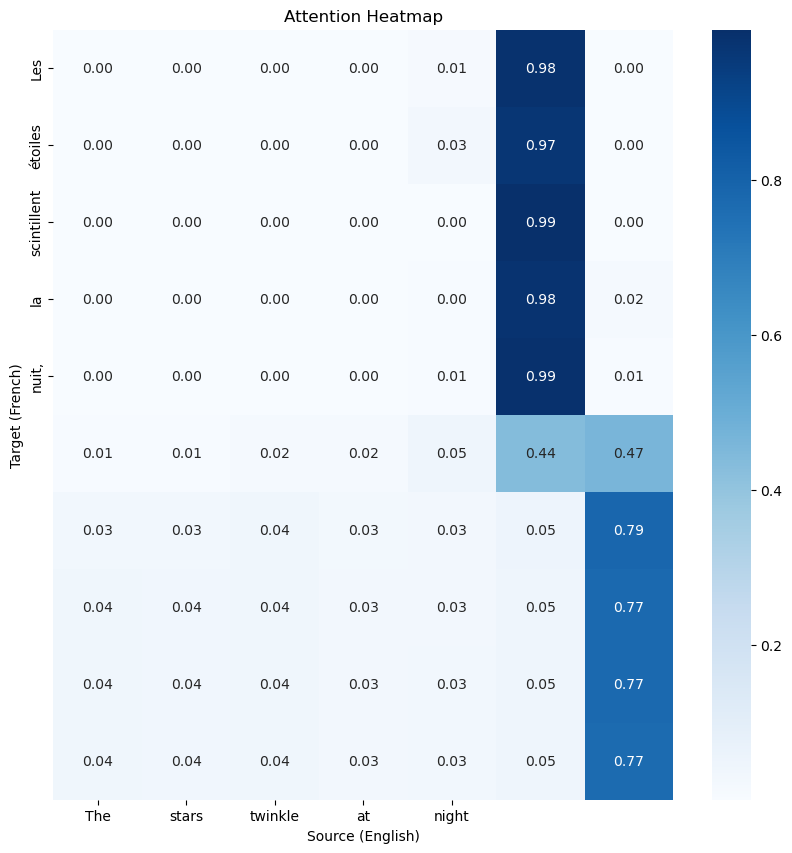

Input: They are students
Target: Ils sont étudiants,
Predicted: Ils sont étudiants,
------------------------------
[[6.0875025e-03 8.3871797e-04 2.0238990e-03 9.7352356e-01 4.8040012e-03
  5.7458761e-03 6.9764014e-03]
 [7.3756091e-03 1.1141931e-03 2.4244506e-03 9.7889745e-01 2.9481945e-03
  3.3174830e-03 3.9225994e-03]
 [7.4259364e-03 1.8937896e-03 4.6158358e-03 9.4783545e-01 1.0949293e-02
  1.2012563e-02 1.5267120e-02]
 [4.8750523e-04 8.8863118e-05 2.7071717e-04 1.9363405e-01 8.1507131e-02
  2.6727268e-01 4.5673904e-01]
 [7.4597599e-04 2.2407938e-04 4.1413060e-04 7.5372132e-03 1.3738693e-01
  3.7159979e-01 4.8209187e-01]
 [1.7845619e-03 1.3689839e-03 1.7763269e-03 8.2222773e-03 1.5927523e-01
  3.7112364e-01 4.5644897e-01]
 [1.8452085e-03 1.4368019e-03 1.8198387e-03 7.6681077e-03 1.4899135e-01
  3.7116373e-01 4.6707493e-01]
 [1.9143665e-03 1.5259780e-03 1.9072196e-03 7.6303333e-03 1.4653873e-01
  3.7083089e-01 4.6965256e-01]
 [1.9229383e-03 1.5387123e-03 1.9178187e-03 7.5900182e-03 1.4

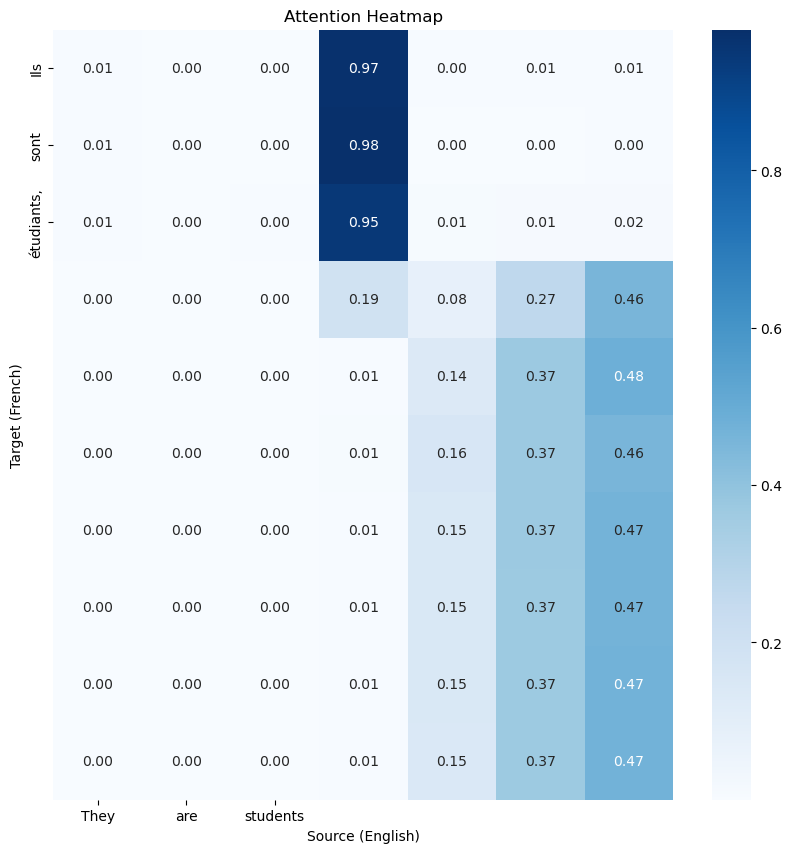

Input: They study French grammar
Target: Ils étudient la grammaire française,
Predicted: Ils étudient la grammaire française,
------------------------------
[[7.7297154e-06 2.3887258e-05 7.9500438e-05 8.1992691e-04 9.9898559e-01
  6.2758751e-05 2.0523565e-05]
 [2.0775595e-05 5.2203453e-05 1.4314163e-04 1.2934761e-03 9.9842584e-01
  4.9462720e-05 1.4980777e-05]
 [1.4891128e-04 2.8352442e-04 5.4737402e-04 1.7577114e-03 9.9610007e-01
  9.4162050e-04 2.2083473e-04]
 [1.5548436e-05 3.8989543e-05 1.0027759e-04 5.0311949e-04 9.9885130e-01
  3.6989336e-04 1.2087852e-04]
 [1.4545188e-06 5.2133892e-06 1.9976771e-05 2.1817013e-04 9.8443025e-01
  4.3227673e-03 1.1002156e-02]
 [6.0601212e-04 1.3024400e-03 2.3337381e-03 4.5994017e-03 9.3865924e-02
  2.7876213e-01 6.1853039e-01]
 [3.9391872e-03 5.1133456e-03 6.0293791e-03 6.6550123e-03 2.5030460e-02
  2.6276395e-01 6.9046861e-01]
 [4.0913625e-03 5.1160231e-03 5.8705891e-03 6.1747464e-03 2.2583019e-02
  2.6136410e-01 6.9480014e-01]
 [3.8484400e-03 4.8

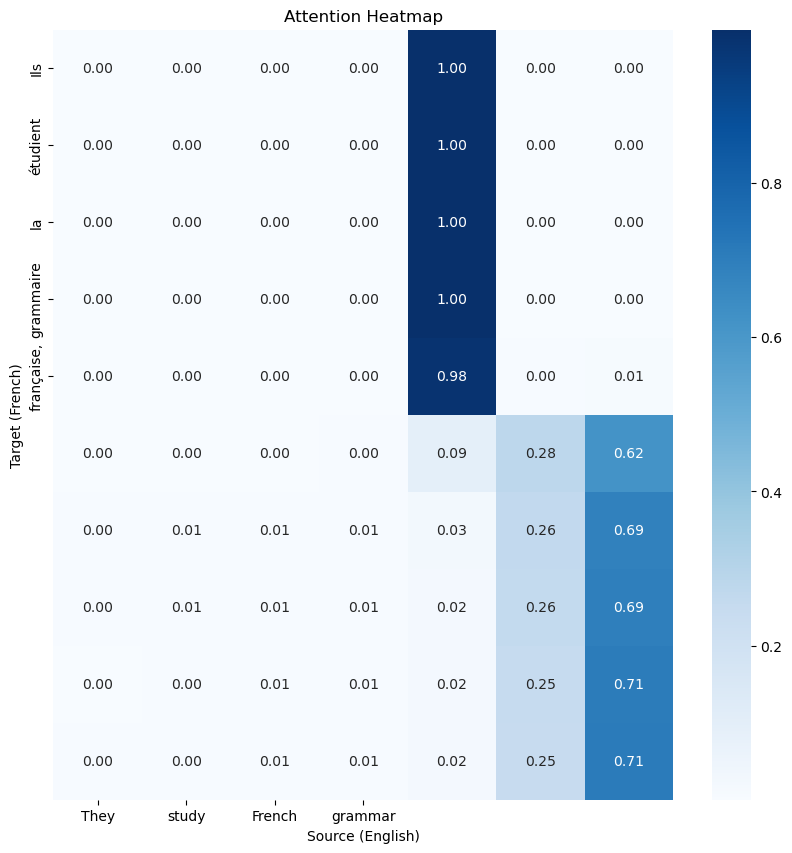

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize attention
def visualize_attention(input_sentence, target_sentence, attention_matrix):

    print(attention_matrix)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(attention_matrix, cmap='Blues', annot=True, fmt=".2f",
                xticklabels=input_sentence, yticklabels=target_sentence, ax=ax)

    plt.xlabel('Source (English)')
    plt.ylabel('Target (French)')
    plt.title('Attention Heatmap')
    plt.show()

# Modified Evaluation Function with Attention Visualization
def evaluate_and_show_examples_with_attention(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    printed_examples = 0

    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden

            predicted_indices = [[] for _ in range(batch_size)]
            attention_matrices = [[] for _ in range(batch_size)]

            # Loop through the target sequence
            for t in range(target_tensor.size(1)):
                output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())
                    attention_matrices[b].append(attn_weights[b].cpu().numpy())

                decoder_input = topi.squeeze().detach()

            # Print and visualize examples
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break

                # Convert predicted indices to words
                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_words = [
                    english_vocab.index2word[idx.item()]
                    for idx in input_tensor[batch_idx]
                    if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]
                ]

                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)
                input_sentence = " ".join(input_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)

                # Display attention matrix
                attention_matrix = np.array(attention_matrices[batch_idx])
                attention_matrix = attention_matrix[:, :len(predicted_words), :len(input_words)]
                visualize_attention(input_words, predicted_words, attention_matrix)
                
                printed_examples += 1
evaluate_and_show_examples_with_attention(encoder, attention_decoder, train_loader, criterion, 5)
